In [1]:
import json
from pprint import pprint

with open('stations.json') as data_file:    
    data = json.load(data_file)

In [2]:
# Load data
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn.preprocessing
from sklearn.linear_model import LogisticRegression
import project_env
from imp import reload
import math

reload(project_env)

%matplotlib inline

In [3]:
stations = pd.read_json('stations.json', 'index').T
stations_df = pd.DataFrame.from_dict(stations['stationBeanList'][0], orient = 'index').T
for i in range(1, 664):
    stations_df = pd.concat([stations_df, pd.DataFrame.from_dict(stations['stationBeanList'][i], orient = 'index').T])
stations_df = stations_df.set_index('id')
stations_df.head()

,totalDocks,postalCode,latitude,city,stationName,stAddress1,testStation,stAddress2,altitude,availableBikes,lastCommunicationTime,statusKey,statusValue,landMark,longitude,availableDocks,location
id,,,,,,,,,,,,,,,,,
72,39,,40.7673,,W 52 St & 11 Ave,W 52 St & 11 Ave,False,,,0,2016-12-03 12:52:42 PM,1,In Service,,-73.9939,38,
79,33,,40.7191,,Franklin St & W Broadway,Franklin St & W Broadway,False,,,31,2016-12-03 12:52:01 PM,1,In Service,,-74.0067,1,
82,27,,40.7112,,St James Pl & Pearl St,St James Pl & Pearl St,False,,,9,2016-12-03 12:52:29 PM,1,In Service,,-74.0002,18,
83,62,,40.6838,,Atlantic Ave & Fort Greene Pl,Atlantic Ave & Fort Greene Pl,False,,,33,2016-12-03 12:52:37 PM,1,In Service,,-73.9763,28,
116,39,,40.7418,,W 17 St & 8 Ave,W 17 St & 8 Ave,False,,,35,2016-12-03 12:53:38 PM,1,In Service,,-74.0015,3,


In [4]:
import os
files = os.listdir('per_station_dev')
type(files)

list

In [5]:
station_ids = []
for i in range(0, len(files)):
    station_ids.append(int(files[i][0:len(files[0])- 4]))

In [6]:
stations_df = stations_df.loc[station_ids, :]

In [7]:
stations_df.head()

,totalDocks,postalCode,latitude,city,stationName,stAddress1,testStation,stAddress2,altitude,availableBikes,lastCommunicationTime,statusKey,statusValue,landMark,longitude,availableDocks,location
id,,,,,,,,,,,,,,,,,
128,30,,40.7271,,MacDougal St & Prince St,MacDougal St & Prince St,False,,,3,2016-12-03 12:51:57 PM,1,In Service,,-74.003,27,
151,33,,40.7221,,Cleveland Pl & Spring St,Cleveland Pl & Spring St,False,,,26,2016-12-03 12:54:56 PM,1,In Service,,-73.9972,7,
161,35,,40.7292,,LaGuardia Pl & W 3 St,LaGuardia Pl & W 3 St,False,,,33,2016-12-03 12:51:54 PM,1,In Service,,-73.9981,0,
174,30,,40.7382,,E 25 St & 1 Ave,E 25 St & 1 Ave,False,,,3,2016-12-03 12:53:39 PM,1,In Service,,-73.9774,25,
229,23,,40.7274,,Great Jones St,Great Jones St,False,,,21,2016-12-03 12:53:21 PM,1,In Service,,-73.9938,1,


In [20]:
stations_df.loc[518, :]

totalDocks                                   39
postalCode                                     
latitude                                40.7478
city                                           
stationName                     E 39 St & 2 Ave
stAddress1                      E 39 St & 2 Ave
testStation                               False
stAddress2                                     
altitude                                       
availableBikes                                1
lastCommunicationTime    2016-12-03 12:54:17 PM
statusKey                                     1
statusValue                          In Service
landMark                                       
longitude                              -73.9734
availableDocks                               35
location                                       
Name: 518, dtype: object

In [8]:
import math

def distance(station_a_id, station_b_id):
    longitude_difference = stations_df.loc[station_a_id, 'longitude'] - stations_df.loc[station_b_id, 'longitude']
    latitude_difference = stations_df.loc[station_a_id, 'latitude'] - stations_df.loc[station_b_id, 'latitude']
    distance = math.sqrt(longitude_difference**2 + latitude_difference**2)
    return distance

In [9]:
def closest_stations(station_a_id, num):
    distances = pd.Series(data=None, index = stations_df.index)
    for station_id in stations_df.index:
        distances[station_id] = distance(station_a_id, station_id)
    distances = distances.sort_values()
    return distances.iloc[1:num+1]   

In [10]:
closest_stations(128, 5)

id
368    0.003384
161    0.005289
151    0.007598
383    0.008572
229    0.009187
dtype: float64

**The `project_env` package**

I wrote this python package so loading and working with data is quicker and easier. There are several convenience methods:
* `load_split_bucket(station_id)` - Load data for a bike station that's already pre-split into train, dev and test. Includes doing data cleaning and thresholding. The output is a dictionary:
```
  {
    'train': (DataFrame, Series),
    'dev': (DataFrame, Series),
    'test': (DataFrame, Series)
  }
```
  Each `(DataFrame, Series)` tuple is the feature values and target variables, respectively.
* `merge_training(split, df)` - Given two outputs of `load()`, append the training set of the second argument to the training set of the first. This is useful when trying to load data from multiple stations, but testing on one station only.
* `binarize(data, target)` - Given output of `load()` and either 1 or -1, binarize the target variable to 0 or 1. Whatever class is in the second argument will become '1' in the new data.

In [11]:
data = project_env.load_split_bucket(519, target='y_60m', log=False)
print('done loading')

done loading


In [12]:
training_X, training_y = data['train']

print(len(training_X.columns))
print(training_X.columns)
#training_X.describe().T

22
Index(['apparentTemperature', 'cloudCover', 'dewPoint', 'humidity',
       'nearestStormDistance', 'ozone', 'precipIntensity', 'precipProbability',
       'pressure', 'temperature', 'visibility', 'windBearing', 'windSpeed',
       'num_bikes_available_scaled', 'num_bikes_disabled_scaled',
       'num_docks_available_scaled', 'day_of_week', 'hour_of_day',
       'is_weekend', 'traffic_0_speed_scrub', 'traffic_1_speed_scrub',
       'traffic_2_speed_scrub'],
      dtype='object')


In [14]:
#modified this to take a loss function and a c-parameter
def do_logreg(split_data, squares=False, plot=True, penalty='l2', C=1e5):
    train_X, train_y = split_data['train']
    dev_X, dev_y = split_data['dev']
    
    logreg = LogisticRegression(penalty=penalty, C=C)
    scaler = sklearn.preprocessing.StandardScaler()
    train_X_scaled = scaler.fit_transform(train_X)
    
    if squares:
        train_X_scaled = np.concatenate([
                train_X_scaled,
                np.square(train_X_scaled)], axis=1)
    print('X shape:', train_X_scaled.shape)
    
    #print(pd.DataFrame(train_X_scaled).describe().T)
    logreg.fit(train_X_scaled, train_y)

    dev_X_scaled = scaler.transform(dev_X)
    if squares:
        dev_X_scaled = np.concatenate([
                dev_X_scaled,
                np.square(dev_X_scaled)], axis=1)
        
    dev_pred = logreg.predict(dev_X_scaled)
    dev_decision = logreg.predict_proba(dev_X_scaled)[:,1]
    acc = sklearn.metrics.accuracy_score(dev_y, dev_pred)
    print('Evaluating on dev set of {} examples'.format(len(dev_y)))
    print('Accuracy:', acc)
    
    print(sklearn.metrics.confusion_matrix(dev_y, dev_pred))

    if plot:
        plt.figure()
        plt.plot(dev_y.as_matrix()[100:500], 'b')
        plt.plot(dev_pred[100:500], 'g')
        plt.plot(0.5 * (dev_y.as_matrix() - dev_pred)[100:500], 'r')
        plt.ylim(-3, 3)
        plt.show()
    
    return logreg, scaler, dev_decision

X shape: (4236, 22)
Evaluating on dev set of 968 examples
Accuracy: 0.810950413223
[[443 142]
 [ 41 342]]


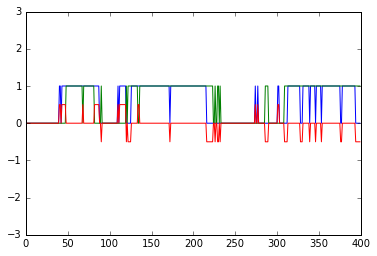

In [15]:
data_empty = project_env.binarize(data, -1)
logreg, scaler, dev_pred = do_logreg(data_empty)

In [22]:
# Add in data from station 518 - E 39 St & 2 Ave - capacity 39
def read_more_data(station_id):
    return project_env.load_split_bucket(station_id, target='y_60m')

more = read_more_data(518)
more['train'][0].describe().T

,count,mean,std,min,25%,50%,75%,max
apparentTemperature,3124.0,56.206869,11.252236,32.67,47.600000,55.570000,64.012500,84.620000
cloudCover,3124.0,0.311469,0.279410,0.00,0.090000,0.230000,0.450000,1.000000
dewPoint,3124.0,43.784062,12.029146,23.02,34.145000,40.620000,54.820000,68.490000
humidity,3124.0,0.626380,0.152359,0.28,0.500000,0.630000,0.730000,0.950000
nearestStormDistance,3124.0,83.956466,132.432326,0.00,8.000000,22.000000,104.000000,715.000000
ozone,3124.0,279.100166,14.499026,248.00,270.130000,276.190000,288.350000,315.310000
precipIntensity,3124.0,0.000582,0.003929,0.00,0.000000,0.000000,0.000000,0.082200
precipProbability,3124.0,0.029513,0.156685,0.00,0.000000,0.000000,0.000000,1.000000
pressure,3124.0,1016.643569,24.752692,477.88,1012.500000,1018.195000,1023.090000,1031.010000
temperature,3124.0,57.095464,10.118811,37.50,49.607500,55.570000,64.012500,83.620000


X shape: (7360, 22)
Evaluating on dev set of 968 examples
Accuracy: 0.778925619835
[[424 161]
 [ 53 330]]


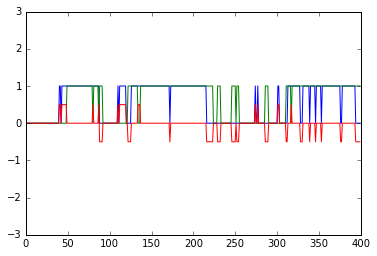

In [23]:
appended = project_env.merge_training(data, more)
appended_empty = project_env.binarize(appended, -1)

a_logreg, a_scaler, a_pred = do_logreg(appended_empty)

In [26]:
list(closest_stations(519, 10).index[1:10])

[472, 527, 540, 505, 507, 477, 492, 174, 491]

In [27]:
#Add more training data for closest 10 stations (already added closest station, this adds in 9 more)

station_ids_to_concat = list(closest_stations(519, 10).index[1:10])
station_ids_data = [read_more_data(sid) for sid in station_ids_to_concat]

In [28]:
app_len = len(appended['train'][0])
more_appended = appended
for df in station_ids_data:
    more_appended = project_env.merge_training(more_appended, df)
    
assert len(appended['train'][0]) == app_len

X shape: (36751, 22)
Evaluating on dev set of 968 examples
Accuracy: 0.816115702479
[[463 122]
 [ 56 327]]


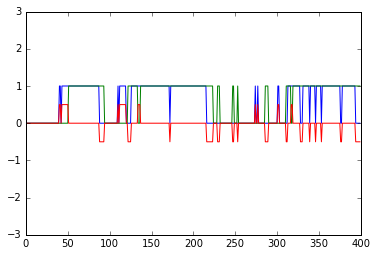

In [29]:
more_appended_empty = project_env.binarize(more_appended, -1)
sq, scl, more_appended_pred = do_logreg(more_appended_empty)

X shape: (4236, 44)
Evaluating on dev set of 968 examples
Accuracy: 0.601239669421
[[222 363]
 [ 23 360]]


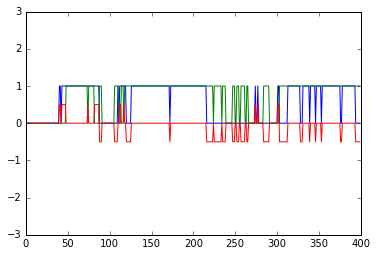

In [30]:
sq, scl, basic_pred_sq = do_logreg(data_empty, squares=True)

# Evaluation

Plot the precision-recall curve for the 4 classifiers:

Model baseline
  Max precision: 0.528301886792 at recall 0.950391644909
  Threshold of max precision: 0.540983606557
Model basic
  Max precision: 0.581469648562 at recall 0.950391644909
  Threshold of max precision: 0.237075253857
Model appended
  Max precision: 0.530523255814 at recall 0.953002610966
  Threshold of max precision: 0.121865585866
Model more_appended
  Max precision: 0.538461538462 at recall 0.950391644909
  Threshold of max precision: 0.0831362448793
Model basic_sq
  Max precision: 0.480895915679 at recall 0.953002610966
  Threshold of max precision: 0.387572925669


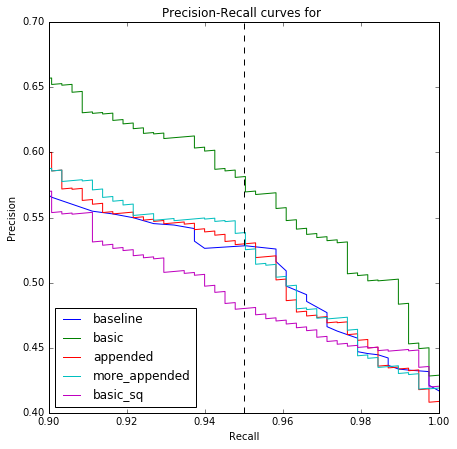

In [31]:
from sklearn.metrics import precision_recall_curve

gold_labels = data_empty['dev'][1]

def pr_curve(predictions, label):
    curve = precision_recall_curve(gold_labels, predictions)
    precision, recall, thresholds = curve
    mp, mr, mt = project_env.max_precision_for_recall(curve)
    print('Model', label)
    print('  Max precision:', mp, 'at recall', mr)
    print('  Threshold of max precision:', mt)
    plt.plot(recall, precision, label=label)
   
plt.figure(figsize=(7, 7))
pr_curve(data_empty['dev'][0]['num_docks_available_scaled'], 'baseline')
pr_curve(dev_pred, 'basic')
pr_curve(a_pred, 'appended')
pr_curve(more_appended_pred, 'more_appended')
pr_curve(basic_pred_sq, 'basic_sq')

plt.xlim([0.9, 1.0])
plt.ylim([0.4, 0.7])
plt.axvline(x=0.95, color='k', linestyle='--')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(loc="lower left")
plt.title('Precision-Recall curves for ')
plt.show()


95% recall means that whenever the model tells a user to go to a station to pick up a bike at a designated time, 5% of the time, the station ends up empty (the bad case).

Given a model satisfies at least 95% recall, a higher precision means fewer occasions where a model turns the user away from the station even though it has bikes available (a more efficient model). So, we want to find a model that maximizes precision given a minimum recall.

In the plot above the `basic` model wins out at around 57% precision at 95% recall. So that means when the model says the station is empty, 57% of the time the station will actually be empty.

### Testing Different Target Variables

In [75]:
targets = ['y_10m','y_15m','y_30m','y_45m','y_60m','y_90m','y_120m']

datasets = dict.fromkeys(targets)

In [76]:
for target in targets:
    datasets[target] = project_env.load_split_bucket(519, target = target, log=False)

In [77]:
binarized_data_empty = dict.fromkeys(targets)
binarized_data_full = dict.fromkeys(targets)

In [78]:
for target in targets:
    binarized_data_empty[target] = project_env.binarize(datasets[target], -1)
    binarized_data_full[target] = project_env.binarize(datasets[target], 1)

In [79]:
logregs_empty = dict.fromkeys(targets)
scalers_empty = dict.fromkeys(targets)
predictions_empty = dict.fromkeys(targets)
logregs_full = dict.fromkeys(targets)
scalers_full = dict.fromkeys(targets)
predictions_full = dict.fromkeys(targets)

X shape: (4289, 22)
Evaluating on dev set of 1002 examples
Accuracy: 0.89620758483
[[546  68]
 [ 36 352]]


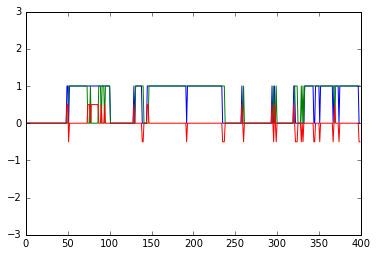

X shape: (4289, 22)
Evaluating on dev set of 1002 examples
Accuracy: 0.957085828343
[[953   2]
 [ 41   6]]


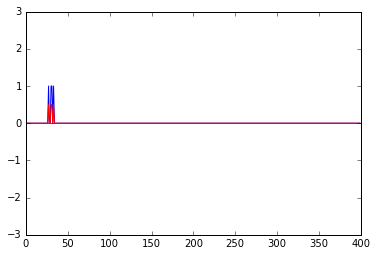

X shape: (4257, 22)
Evaluating on dev set of 993 examples
Accuracy: 0.883182275932
[[516  81]
 [ 35 361]]


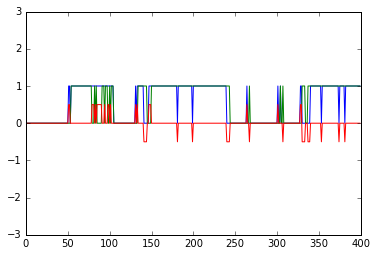

X shape: (4257, 22)
Evaluating on dev set of 993 examples
Accuracy: 0.952668680765
[[945   1]
 [ 46   1]]


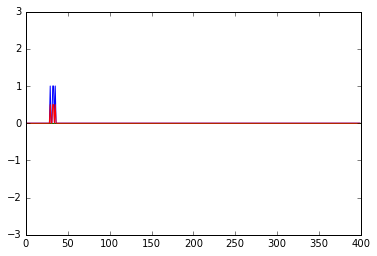

X shape: (4298, 22)
Evaluating on dev set of 988 examples
Accuracy: 0.861336032389
[[499 102]
 [ 35 352]]


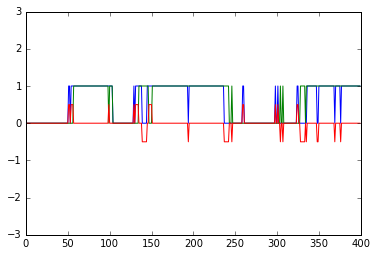

X shape: (4298, 22)
Evaluating on dev set of 988 examples
Accuracy: 0.952429149798
[[941   0]
 [ 47   0]]


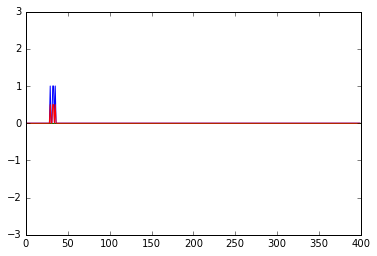

X shape: (4228, 22)
Evaluating on dev set of 983 examples
Accuracy: 0.840284842319
[[481 120]
 [ 37 345]]


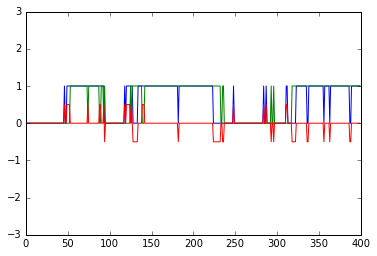

X shape: (4228, 22)
Evaluating on dev set of 983 examples
Accuracy: 0.951169888098
[[935   0]
 [ 48   0]]


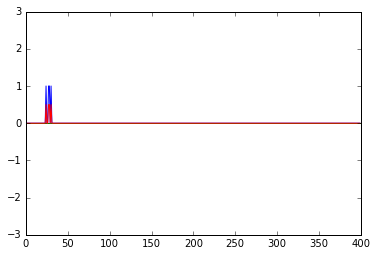

X shape: (4236, 22)
Evaluating on dev set of 968 examples
Accuracy: 0.810950413223
[[443 142]
 [ 41 342]]


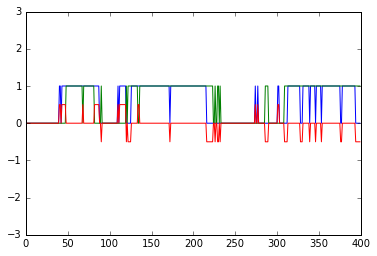

X shape: (4236, 22)
Evaluating on dev set of 968 examples
Accuracy: 0.95041322314
[[920   0]
 [ 48   0]]


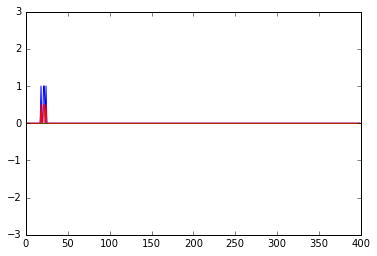

X shape: (4124, 22)
Evaluating on dev set of 954 examples
Accuracy: 0.781970649895
[[418 162]
 [ 46 328]]


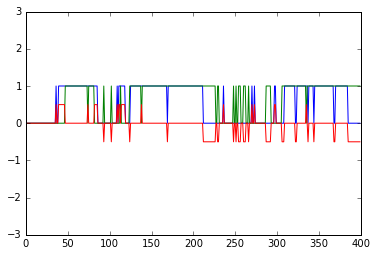

X shape: (4124, 22)
Evaluating on dev set of 954 examples
Accuracy: 0.952830188679
[[909   0]
 [ 45   0]]


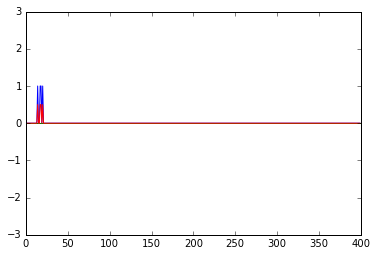

X shape: (4040, 22)
Evaluating on dev set of 942 examples
Accuracy: 0.767515923567
[[399 177]
 [ 42 324]]


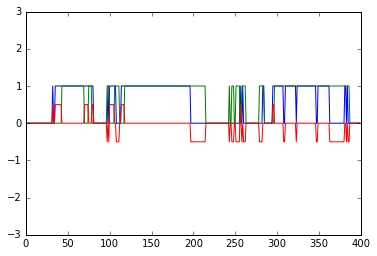

X shape: (4040, 22)
Evaluating on dev set of 942 examples
Accuracy: 0.954352441614
[[899   0]
 [ 43   0]]


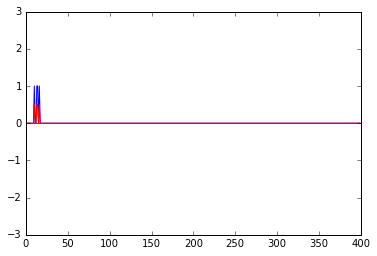

In [80]:
for target in targets:
    logregs_empty[target], scalers_empty[target], predictions_empty[target] = do_logreg(binarized_data_empty[target])
    logregs_full[target], scalers_full[target], predictions_full[target] = do_logreg(binarized_data_full[target])

### Evaluating Accuracy at Different Targets

#### Empty

Model y_10m
  Max precision: 0.736526946108 at recall 0.951030927835
  Threshold of max precision: 0.117250850911
Model y_15m
  Max precision: 0.727799227799 at recall 0.95202020202
  Threshold of max precision: 0.166880407542
Model y_30m
  Max precision: 0.685288640596 at recall 0.950904392765
  Threshold of max precision: 0.25896608677
Model y_45m
  Max precision: 0.641342756184 at recall 0.950261780105
  Threshold of max precision: 0.30002509002
Model y_60m
  Max precision: 0.581469648562 at recall 0.950391644909
  Threshold of max precision: 0.237075253857
Model y_90m
  Max precision: 0.55625 at recall 0.951871657754
  Threshold of max precision: 0.301549750887
Model y_120m
  Max precision: 0.553090332805 at recall 0.953551912568
  Threshold of max precision: 0.385048916308


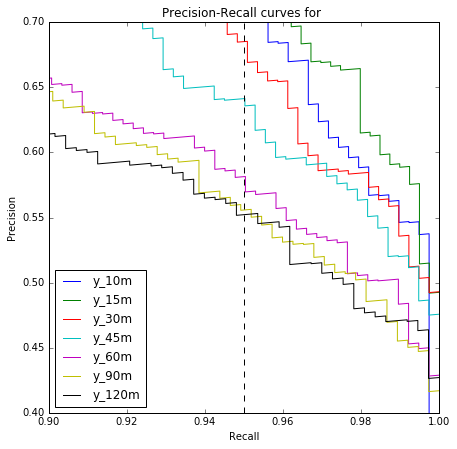

In [81]:
#modified pr_curve function to take "gold_labels" as a parameter
def pr_curve(predictions, label, gold_labels):
    curve = precision_recall_curve(gold_labels, predictions)
    precision, recall, thresholds = curve
    mp, mr, mt = project_env.max_precision_for_recall(curve)
    print('Model', label)
    print('  Max precision:', mp, 'at recall', mr)
    print('  Threshold of max precision:', mt)
    plt.plot(recall, precision, label=label)

plt.figure(figsize=(7, 7))
for target in targets:
    pr_curve(predictions_empty[target], target, binarized_data_empty[target]['dev'][1])

plt.xlim([0.9, 1.0])
plt.ylim([0.4, 0.7])
plt.axvline(x=0.95, color='k', linestyle='--')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(loc="lower left")
plt.title('Precision-Recall curves for ')
plt.show() #the 60m one should be same as the first "basic", and it is

#### Full

Model y_10m
  Max precision: 0.671641791045 at recall 0.957446808511
  Threshold of max precision: 0.0846728322053
Model y_15m
  Max precision: 0.535714285714 at recall 0.957446808511
  Threshold of max precision: 0.0153294654791
Model y_30m
  Max precision: 0.40350877193 at recall 0.978723404255
  Threshold of max precision: 0.00591762609846
Model y_45m
  Max precision: 0.389830508475 at recall 0.958333333333
  Threshold of max precision: 0.0138377878306
Model y_60m
  Max precision: 0.319444444444 at recall 0.958333333333
  Threshold of max precision: 0.0084663560742
Model y_90m
  Max precision: 0.137380191693 at recall 0.955555555556
  Threshold of max precision: 0.0056386496408
Model y_120m
  Max precision: 0.100244498778 at recall 0.953488372093
  Threshold of max precision: 0.00371200215064


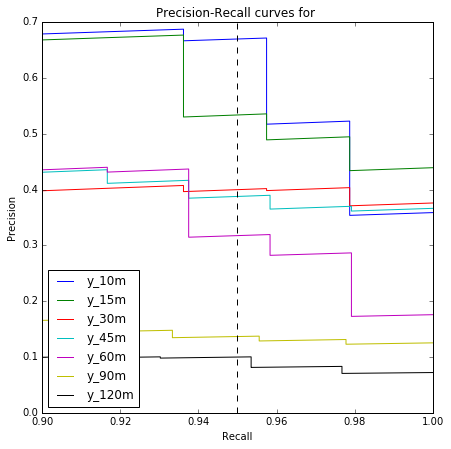

In [84]:
plt.figure(figsize=(7, 7))
for target in targets:
    pr_curve(predictions_full[target], target, binarized_data_full[target]['dev'][1])

plt.xlim([0.9, 1.0])
plt.ylim([0, 0.7])
plt.axvline(x=0.95, color='k', linestyle='--')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(loc="lower left")
plt.title('Precision-Recall curves for ')
plt.show()